# Earthquake Prediction using Swarm AI and MARL

This notebook implements a comprehensive solution for earthquake prediction using:
- Multi-Agent Reinforcement Learning (MARL)
- Swarm Intelligence
- Deep Learning

## Setup and Imports

In [4]:
!pip install jupyter notebook pandas numpy torch scikit-learn matplotlib seaborn pettingzoo gym

  Using cached jupyter-1.1.1-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached jupyter_console-6.6.3-py3-none-any.whl.metadata (5.8 kB)
  Using cached nbconvert-7.16.6-py3-none-any.whl.metadata (8.5 kB)
  Using cached jupyter_server-2.15.0-py3-none-any.whl.metadata (8.4 kB)
  Using cached jupyterlab_server-2.27.3-py3-none-any.whl.metadata (5.9 kB)
  Using cached notebook_shim-0.2.4-py3-none-any.whl.metadata (4.0 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached argon2_cffi-23.1.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached jupyter_events-0.12.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached jupyter_server_terminals-0.5.3-py3-none-any.whl.metadata (5.6 kB)
  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached overrides-7.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached prometheus_client-0.21.1-py3-none-any.whl.metadata (1.8 kB)
  Using cached pywinpty-2.0.15-cp312-cp312-win_amd64.whl.metadata (5.2 kB)
  Using c


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import Dict, List, Tuple
import gym
from pettingzoo import ParallelEnv
from sklearn.preprocessing import StandardScaler

torch.manual_seed(42)
np.random.seed(42)

## Generate Sample Seismic Data

In [6]:
def generate_sample_seismic_data(num_records=1000):
    # Generate timestamps
    base_date = datetime(2024, 1, 1)
    timestamps = [base_date + timedelta(hours=i) for i in range(num_records)]
    
    # Generate sample data
    data = {
        'time': timestamps,
        'latitude': np.random.uniform(25.0, 45.0, num_records),
        'longitude': np.random.uniform(120.0, 150.0, num_records),
        'depth': np.random.uniform(0, 100, num_records),
        'magnitude': np.random.normal(3.0, 1.0, num_records)
    }
    
    # Create some significant earthquakes
    significant_indices = np.random.choice(num_records, size=int(num_records * 0.1))
    data['magnitude'][significant_indices] = np.random.normal(5.0, 0.5, len(significant_indices))
    
    # Create DataFrame
    df = pd.DataFrame(data)
    df = df.sort_values('time')
    
    return df

# Generate and display sample data
seismic_df = generate_sample_seismic_data()
print("Sample seismic data:")
seismic_df.head()

Sample seismic data:


,time,latitude,longitude,depth,magnitude
0,2024-01-01 00:00:00,32.490802,125.553988,26.170568,4.059936
1,2024-01-01 01:00:00,44.014286,136.257028,24.697880,3.617006
2,2024-01-01 02:00:00,39.639879,146.188375,90.625458,3.683569
3,2024-01-01 03:00:00,36.973170,141.966747,24.954620,1.634044
4,2024-01-01 04:00:00,28.120373,144.196834,27.194973,4.211944


## Visualize Seismic Data

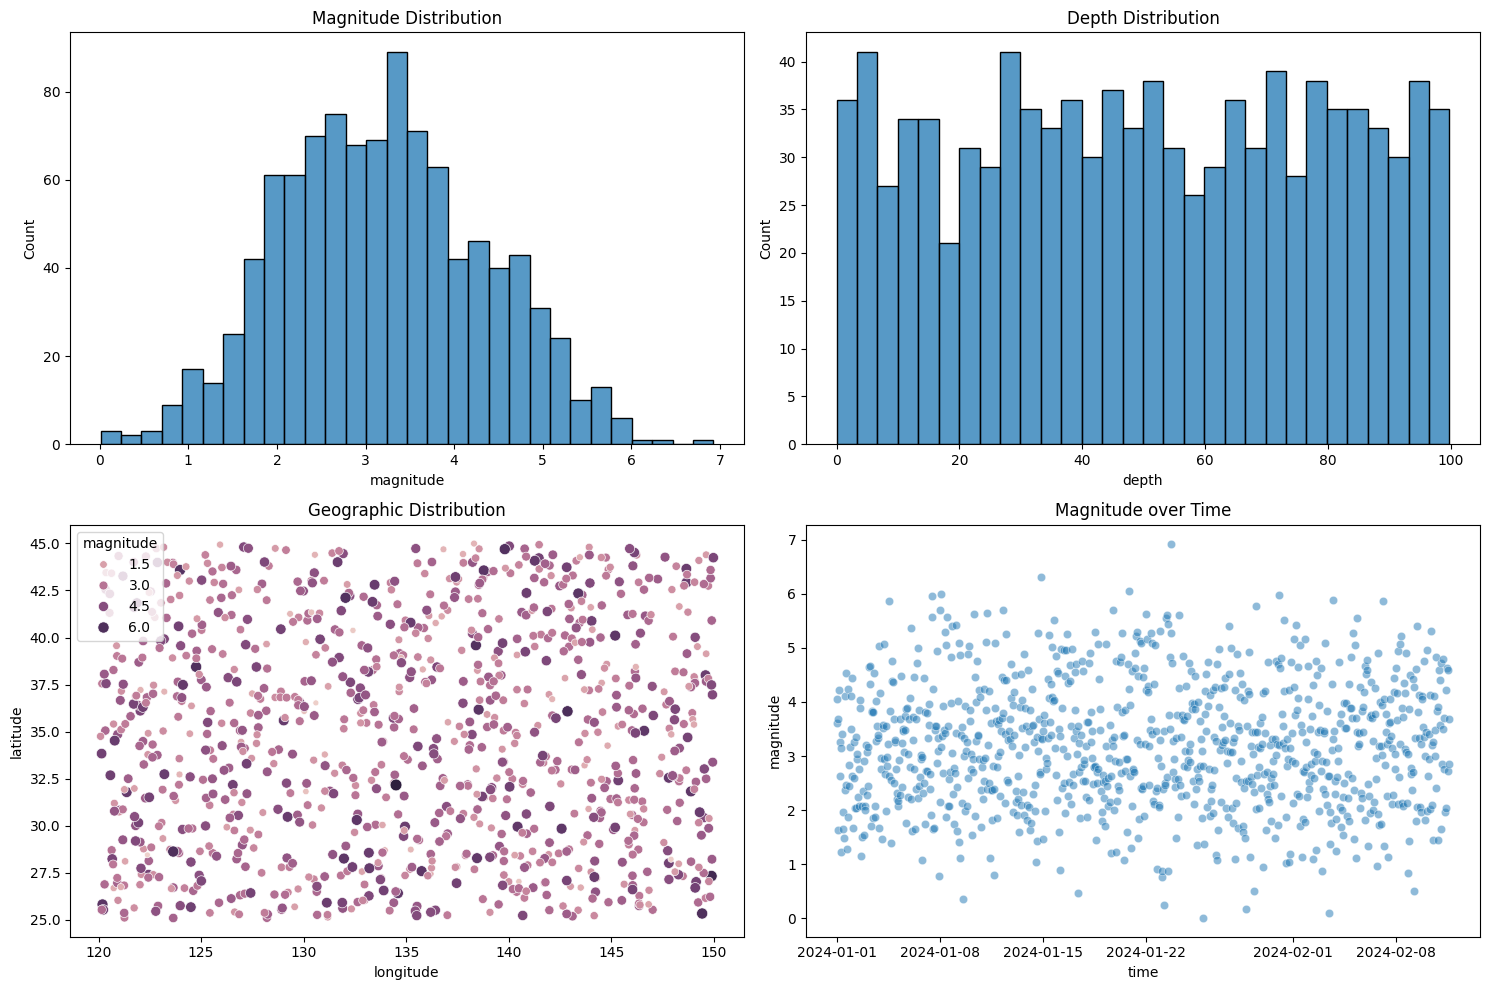

In [7]:
def plot_seismic_data(df):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Magnitude distribution
    sns.histplot(data=df, x='magnitude', bins=30, ax=axes[0,0])
    axes[0,0].set_title('Magnitude Distribution')
    
    # Depth distribution
    sns.histplot(data=df, x='depth', bins=30, ax=axes[0,1])
    axes[0,1].set_title('Depth Distribution')
    
    # Geographic distribution
    sns.scatterplot(data=df, x='longitude', y='latitude', 
                    hue='magnitude', size='magnitude',
                    ax=axes[1,0])
    axes[1,0].set_title('Geographic Distribution')
    
    # Magnitude over time
    sns.scatterplot(data=df, x='time', y='magnitude',
                    alpha=0.5, ax=axes[1,1])
    axes[1,1].set_title('Magnitude over Time')
    plt.tight_layout()
    plt.show()

plot_seismic_data(seismic_df)

## Environment Implementation

In [8]:
class EarthquakeEnv(ParallelEnv):
    def __init__(self, num_agents: int, grid_size: int = 50):
        super().__init__()
        self.num_agents = num_agents
        self.grid_size = grid_size
        
        # Define action and observation spaces
        self.action_spaces = {
            f"agent_{i}": gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
            for i in range(num_agents)
        }
        
        self.observation_spaces = {
            f"agent_{i}": gym.spaces.Dict({
                "position": gym.spaces.Box(low=0, high=grid_size, shape=(2,), dtype=np.float32),
                "seismic_features": gym.spaces.Box(low=-np.inf, high=np.inf, shape=(4,), dtype=np.float32),
                "neighbor_data": gym.spaces.Box(low=-np.inf, high=np.inf, shape=(8,), dtype=np.float32)
            }) for i in range(num_agents)
        }

    def reset(self):
        self.agents = [f"agent_{i}" for i in range(self.num_agents)]
        self.agent_positions = {
            agent: np.random.uniform(0, self.grid_size, size=(2,))
            for agent in self.agents
        }
        return self._get_observations()

    def step(self, actions):
        for agent_id, action in actions.items():
            self.agent_positions[agent_id] += action
            self.agent_positions[agent_id] = np.clip(
                self.agent_positions[agent_id], 0, self.grid_size
            )
        
        observations = self._get_observations()
        rewards = self._compute_rewards(actions)
        dones = {agent: False for agent in self.agents}
        infos = {agent: {} for agent in self.agents}
        
        return observations, rewards, dones, infos

    def _get_observations(self):
        observations = {}
        for agent in self.agents:
            observations[agent] = {
                "position": self.agent_positions[agent],
                "seismic_features": self._get_seismic_features(agent),
                "neighbor_data": self._get_neighbor_data(agent)
            }
        return observations

    def _get_seismic_features(self, agent):
        return np.random.normal(0, 1, size=(4,))

    def _get_neighbor_data(self, agent):
        current_pos = self.agent_positions[agent]
        neighbor_data = []
        for other_agent in self.agents:
            if other_agent != agent:
                other_pos = self.agent_positions[other_agent]
                distance = np.linalg.norm(current_pos - other_pos)
                neighbor_data.extend([distance, *other_pos])
        return np.array(neighbor_data[:8])

    def _compute_rewards(self, actions):
        return {agent: np.random.uniform(-1, 1) for agent in self.agents}

## Swarm Agent Implementation

In [9]:
class SwarmAgent(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int, hidden_dim: int = 256):
        super().__init__()
        self.obs_encoder = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        self.policy_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        
        self.value_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
        self.velocity = torch.zeros(action_dim)
        self.best_position = None
        self.best_fitness = float('-inf')
    
    def forward(self, obs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        encoded = self.obs_encoder(obs)
        action_logits = self.policy_head(encoded)
        value = self.value_head(encoded)
        return action_logits, value
    
    def update_position_pso(self, global_best, w=0.7, c1=1.5, c2=1.5):
        r1, r2 = torch.rand(1), torch.rand(1)
        self.velocity = (w * self.velocity + 
                        c1 * r1 * (self.best_position - self.get_position()) +
                        c2 * r2 * (global_best - self.get_position()))
        new_position = self.get_position() + self.velocity
        self.set_position(new_position)
    
    def get_position(self):
        return torch.cat([p.data.flatten() for p in self.parameters()])
    
    def set_position(self, position):
        start = 0
        for param in self.parameters():
            num_params = param.numel()
            param.data = position[start:start + num_params].reshape(param.shape)
            start += num_params

class SwarmNetwork:
    def __init__(self, num_agents: int, obs_dim: int, action_dim: int):
        self.agents = [SwarmAgent(obs_dim, action_dim) for _ in range(num_agents)]
        self.global_best_position = None
        self.global_best_fitness = float('-inf')
    
    def update_swarm(self, fitness_scores: List[float]):
        for agent, fitness in zip(self.agents, fitness_scores):
            if fitness > agent.best_fitness:
                agent.best_fitness = fitness
                agent.best_position = agent.get_position()
                
                if fitness > self.global_best_fitness:
                    self.global_best_fitness = fitness
                    self.global_best_position = agent.get_position()
        
        for agent in self.agents:
            agent.update_position_pso(self.global_best_position)

## Training Implementation

In [10]:
class Trainer:
    def __init__(self,
                 num_agents: int,
                 obs_dim: int,
                 action_dim: int,
                 learning_rate: float = 3e-4):
        self.env = EarthquakeEnv(num_agents)
        self.swarm_network = SwarmNetwork(num_agents, obs_dim, action_dim)
        self.optimizers = [
            Adam(agent.parameters(), lr=learning_rate)
            for agent in self.swarm_network.agents
        ]
        
        self.training_history = {
            'episode_rewards': [],
            'average_fitness': []
        }
    
    def train_episode(self, max_steps: int = 1000) -> Tuple[float, List[float]]:
        observations = self.env.reset()
        episode_rewards = []
        swarm_fitness_scores = [0] * len(self.swarm_network.agents)
        
        for step in range(max_steps):
            actions = {}
            for idx, agent in enumerate(self.swarm_network.agents):
                obs = torch.FloatTensor(self._process_observation(
                    observations[f"agent_{idx}"]))
                action_logits, value = agent(obs)
                action = torch.tanh(action_logits).detach().numpy()
                actions[f"agent_{idx}"] = action
            
            new_observations, rewards, dones, _ = self.env.step(actions)
            
            for idx, reward in rewards.items():
                agent_idx = int(idx.split('_')[1])
                swarm_fitness_scores[agent_idx] += reward
            
            episode_rewards.append(sum(rewards.values()))
            observations = new_observations
            
            if all(dones.values()):
                break
        
        self.swarm_network.update_swarm(swarm_fitness_scores)
        
        # Update training history
        self.training_history['episode_rewards'].append(sum(episode_rewards))
        self.training_history['average_fitness'].append(np.mean(swarm_fitness_scores))
        
        return sum(episode_rewards), swarm_fitness_scores
    
    def _process_observation(self, obs: dict) -> np.ndarray:
        return np.concatenate([
            obs['position'],
            obs['seismic_features'],
            obs['neighbor_data']
        ])
    
    def plot_training_history(self):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        # Plot episode rewards
        ax1.plot(self.training_history['episode_rewards'])
        ax1.set_title('Episode Rewards over Time')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Total Reward')
        
        # Plot average fitness
        ax2.plot(self.training_history['average_fitness'])
        ax2.set_title('Average Agent Fitness over Time')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Average Fitness')
        
        plt.tight_layout()
        plt.show()

## Run Training

In [12]:
# Training parameters
num_agents = 10
obs_dim = 14  # position(2) + seismic_features(4) + neighbor_data(8)
action_dim = 2
num_episodes = 100  # Reduced for demonstration

# Initialize trainer
trainer = Trainer(num_agents, obs_dim, action_dim)

# Training loop
for episode in range(num_episodes):
    total_reward, fitness_scores = trainer.train_episode()
    
    if episode % 10 == 0:
        print(f"Episode {episode}")
        print(f"Total Reward: {total_reward:.2f}")
        print(f"Average Agent Fitness: {np.mean(fitness_scores):.2f}")
        print("-" * 50)

# Plot training results
trainer.plot_training_history()

AttributeError: property 'num_agents' of 'EarthquakeEnv' object has no setter

## Evaluate Model Performance

In [ ]:
def evaluate_model(trainer, num_evaluation_episodes=10):
    evaluation_rewards = []
    evaluation_fitness = []
    
    for episode in range(num_evaluation_episodes):
        total_reward, fitness_scores = trainer.train_episode()
        evaluation_rewards.append(total_reward)
        evaluation_fitness.append(np.mean(fitness_scores))
    
    print("\nModel Evaluation Results:")
    print(f"Average Episode Reward: {np.mean(evaluation_rewards):.2f} ± {np.std(evaluation_rewards):.2f}")
    print(f"Average Agent Fitness: {np.mean(evaluation_fitness):.2f} ± {np.std(evaluation_fitness):.2f}")

# Run evaluation
evaluate_model(trainer)

## Visualize Agent Behavior

In [ ]:
def visualize_agent_behavior(trainer, steps=50):
    observations = trainer.env.reset()
    
    positions_history = []
    
    for step in range(steps):
        actions = {}
        current_positions = {}
        
        for idx, agent in enumerate(trainer.swarm_network.agents):
            obs = torch.FloatTensor(trainer._process_observation(
                observations[f"agent_{idx}"]))
            action_logits, _ = agent(obs)
            action = torch.tanh(action_logits).detach().numpy()
            actions[f"agent_{idx}"] = action
            current_positions[f"agent_{idx}"] = observations[f"agent_{idx}"]["position"]
        
        positions_history.append(current_positions)
        observations, _, _, _ = trainer.env.step(actions)
    
    # Visualize agent movements
    plt.figure(figsize=(10, 10))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(trainer.swarm_network.agents)))
    
    for idx, agent_id in enumerate(trainer.env.agents):
        positions = np.array([pos[agent_id] for pos in positions_history])
        plt.plot(positions[:, 0], positions[:, 1], 'o-', 
                 color=colors[idx], label=f'Agent {idx}',
                 alpha=0.5, markersize=3)
    
    plt.title('Agent Movement Patterns')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# Visualize agent behavior
visualize_agent_behavior(trainer)